In [1]:
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import utils
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression

# Warning suppression
import warnings
from sklearn.exceptions import ConvergenceWarning

In [2]:
df = pd.read_csv('data/diabetes_binary_health_indicators_BRFSS2015.csv')
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [3]:
X = df.copy().drop('Diabetes_binary', axis=1)
y = df['Diabetes_binary'].copy()
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Diabetes_binary, dtype: float64

## Run model without tuning

c:\Users\fuze0\anaconda3\envs\dev\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Balanced Accuracy Score: 0.5608787407362351
              precision    recall  f1-score   support

         0.0       0.88      0.98      0.93     54657
         1.0       0.53      0.14      0.22      8763

    accuracy                           0.86     63420
   macro avg       0.70      0.56      0.57     63420
weighted avg       0.83      0.86      0.83     63420



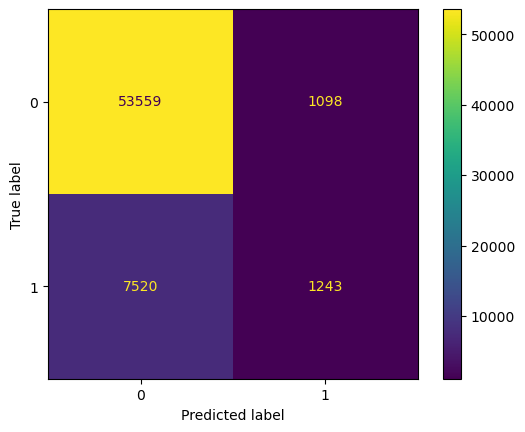

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
baseline_lrm = utils.create_model(utils.Model.LOGISTIC_REGRESSION, {'random_state': 42})
baseline_lrm.fit(X_train, y_train)
baseline_pred = baseline_lrm.predict(X_test)

cmd = utils.confusion_matrix_plot(y_test, baseline_pred, [0, 1])
cmd.plot()
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_test, baseline_pred)}")
print(classification_report(y_test, baseline_pred))

## Check if data is balanced

In [5]:
df['Diabetes_binary'].value_counts()

Diabetes_binary
0.0    218334
1.0     35346
Name: count, dtype: int64

## Use VIF to cut back on features

In [6]:
vif_list = utils.vif_removal_priority(X, 10)
vif_list

[['Education', 29.507416450234114],
 ['CholCheck', 22.235530259486595],
 ['AnyHealthcare', 18.1270116599421],
 ['BMI', 14.66476984201411]]

In [7]:
X = X.drop(['CholCheck', 'Education', 'AnyHealthcare', 'BMI'], axis=1)
X.head()

,HighBP,HighChol,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Income
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,3.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,1.0
2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,8.0
3,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,6.0
4,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,4.0


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(len(X_train))

190260


In [9]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
print(len(X_resampled))
print(len(X_test))

53166
63420


In [10]:
lrm = utils.create_model(utils.Model.LOGISTIC_REGRESSION, {'random_state': 42})
lrm_us = utils.create_model(utils.Model.LOGISTIC_REGRESSION, {'random_state': 42})

lrm.fit(X_train, y_train)
lrm_us.fit(X_resampled, y_resampled)

pred = lrm.predict(X_test)
pred_us = lrm_us.predict(X_test)

results = []

results.append({
    'name': 'Baseline LRM',
    'acc_score': accuracy_score(y_test, pred),
    'train_score': lrm.score(X_train, y_train),
    'test_score': lrm.score(X_test, y_test),
    'balanced_score': balanced_accuracy_score(y_test, pred)
})
results.append({
    'name': 'Undersampled LRM',
    'acc_score': accuracy_score(y_test, pred_us),
    'train_score': lrm_us.score(X_resampled, y_resampled),
    'test_score': lrm_us.score(X_test, y_test),
    'balanced_score': balanced_accuracy_score(y_test, pred_us)
})

results_df = pd.DataFrame(results)
results_df

print(classification_report(y_test, pred))
print(classification_report(y_test, pred_us))


c:\Users\fuze0\anaconda3\envs\dev\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\fuze0\anaconda3\envs\dev\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

              precision    recall  f1-score   support

         0.0       0.87      0.98      0.92     54657
         1.0       0.48      0.12      0.19      8763

    accuracy                           0.86     63420
   macro avg       0.68      0.55      0.56     63420
weighted avg       0.82      0.86      0.82     63420

              precision    recall  f1-score   support

         0.0       0.95      0.71      0.81     54657
         1.0       0.30      0.76      0.43      8763

    accuracy                           0.72     63420
   macro avg       0.62      0.74      0.62     63420
weighted avg       0.86      0.72      0.76     63420



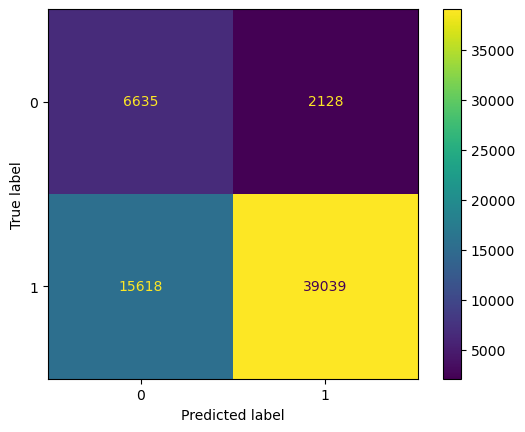

In [11]:
cmd = utils.confusion_matrix_plot(y_test, pred_us, [1, 0])
cmd.plot()

In [12]:
lrm = utils.create_model(utils.Model.LOGISTIC_REGRESSION, {'random_state': 42})
lrm.fit(X_resampled, y_resampled)

c:\Users\fuze0\anaconda3\envs\dev\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [13]:
pred = lrm.predict(X_test)

In [14]:
print(classification_report(y_test, pred,
                            target_names=["negative", "positive"]))
print(balanced_accuracy_score(y_test, pred))

              precision    recall  f1-score   support

    negative       0.95      0.71      0.81     54657
    positive       0.30      0.76      0.43      8763

    accuracy                           0.72     63420
   macro avg       0.62      0.74      0.62     63420
weighted avg       0.86      0.72      0.76     63420

0.7357075697692228


In [15]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100], #, 1000],  
    'tol': [0.01, 0.001, 0.0001, 0.00001], #, 0.001, 0.0001], 
    'solver': ['newton-cholesky', 'sag', 'saga'],
    'penalty': ['l2', None],
    'max_iter': [50, 100, 200]
}

lrm_grid = LogisticRegression()
grid = GridSearchCV(lrm_grid, param_grid, verbose=3, n_jobs=5)
# grid = GridSearchCV(lrm_grid, param_grid, verbose=3)
grid.fit(X_resampled, y_resampled)


Fitting 5 folds for each of 360 candidates, totalling 1800 fits


GridSearchCV(estimator=LogisticRegression(), n_jobs=5,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'max_iter': [50, 100, 200], 'penalty': ['l2', None],
                         'solver': ['newton-cholesky', 'sag', 'saga'],
                         'tol': [0.01, 0.001, 0.0001, 1e-05]},
             verbose=3)

In [16]:
print(grid.best_params_) 
grid_pred = grid.predict(X_test)
print(classification_report(y_test, grid_pred, target_names=['negative', 'positive']))
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_test, grid_pred)}")

{'C': 10, 'max_iter': 50, 'penalty': 'l2', 'solver': 'sag', 'tol': 0.01}
              precision    recall  f1-score   support

    negative       0.95      0.71      0.81     54657
    positive       0.30      0.76      0.43      8763

    accuracy                           0.72     63420
   macro avg       0.62      0.74      0.62     63420
weighted avg       0.86      0.72      0.76     63420

Balanced Accuracy Score: 0.7350841086408739


In [30]:
# print(grid.best_estimator_.coef_[0])
# print(grid.best_estimator_.feature_names_in_)
feature_importance = pd.DataFrame({
    'feature': grid.best_estimator_.feature_names_in_,
    'importance': grid.best_estimator_.coef_[0]
})
# feature_importance.loc[[abs(feature_importance['importance']) > 0.5]]
feature_importance #.iloc[[0, 8, 10, 1]]

,feature,importance
0,HighBP,0.888318
1,HighChol,0.587190
2,Smoker,-0.032565
3,Stroke,0.114421
4,HeartDiseaseorAttack,0.229498
5,PhysActivity,-0.113824
6,Fruits,-0.111024
7,Veggies,-0.049401
8,HvyAlcoholConsump,-0.846604
9,NoDocbcCost,0.007002


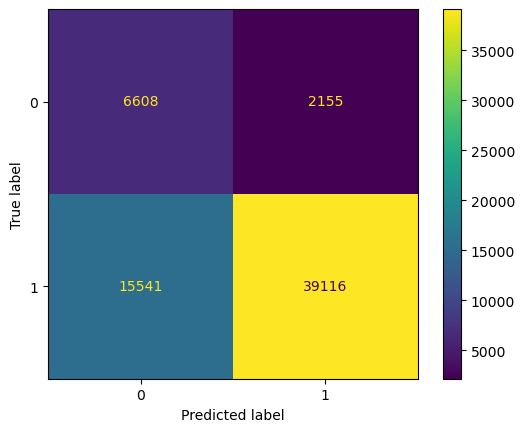

In [20]:
grid_cmd = utils.confusion_matrix_plot(y_test, grid_pred, [1, 0])
grid_cmd.plot()